# Test With Indipendant Embedding Models

# Imports

In [1]:
import os
import pickle
import transformers
import torch
from transformers import AutoTokenizer, AutoModel
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer

# Environment Setup

In [2]:
# There are important!
torch.backends.cuda.enable_mem_efficient_sdp(False)
torch.backends.cuda.enable_flash_sdp(False)

## Model Initialization

### infly/inf-retriever-v1

In [3]:
# model_id = "/media/ANONYMOUS/4TB_2/LLM_models/infly/inf-retriever-v1"

# tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True)
# model = AutoModel.from_pretrained(model_id, trust_remote_code=True, torch_dtype=torch.bfloat16, device_map="cuda")
# max_length = 512

### infly/inf-retriever-v1-1.5b

In [4]:
model_id = "/media/ANONYMOUS/4TB_2/LLM_models/infly/inf-retriever-v1-1.5b"

model = SentenceTransformer(model_id, trust_remote_code=True)
model.max_seq_length = 8192

# Get Dataset

In [5]:
project_base_path = os.path.dirname(os.path.dirname(os.getcwd()))
project_base_path

'/media/ANONYMOUS/4TB_1/Projects/FALCON'

In [6]:
gpt4o_generated_cti_path = os.path.join(project_base_path, "data/generation/snort/snort3-community-rules_v1.pkl")
gpt4o_generated_cti_path

'/media/ANONYMOUS/4TB_1/Projects/FALCON/data/generation/snort/snort3-community-rules_v1.pkl'

In [7]:
def load_from_pickle(file_path):
    """
    Loads data from a pickle file.

    :param file_path: Path to the pickle file
    :return: Loaded data
    """
    try:
        with open(file_path, 'rb') as file:
            return pickle.load(file)
    except Exception as e:
        print(f"Error loading data from pickle: {e}")
        return None

In [8]:
# Load the data back from the pickle file
file_path = gpt4o_generated_cti_path

gpt_snort_cti_dict = load_from_pickle(file_path)
size = len(gpt_snort_cti_dict.keys()) 
print(size)

4017


In [9]:
def get_first_n_elements(dictionary: dict, n: int) -> dict:
    """
    Get the first n elements of a dictionary.

    :param dictionary: The input dictionary
    :param n: The number of elements to retrieve
    :return: A dictionary with the first n elements
    """
    return dict(list(dictionary.items())[:n])

In [10]:
snort_cti_sample_dict = get_first_n_elements(gpt_snort_cti_dict, 10)

In [11]:
snort_cti_sample_dict

{'alert tcp $HOME_NET 2589 -> $EXTERNAL_NET any ( msg:"MALWARE-BACKDOOR - Dagger_1.4.0"; flow:to_client,established; content:"2|00 00 00 06 00 00 00|Drives|24 00|",depth 16; metadata:ruleset community; classtype:misc-activity; sid:105; rev:14; )': '    Title: Detection of Dagger 1.4.0 Backdoor Activity Over TCP\n\n    Threat Category: Malware – Backdoor\n\n    Threat Name: Dagger 1.4.0\n\n    Detection Summary:\n\n    This signature is designed to detect network traffic associated with the Dagger 1.4.0 backdoor. The traffic is characterized by a specific sequence of bytes ("2|00 00 00 06 00 00 00|Drives|24 00|") found within the first 16 bytes of the data payload. This communication occurs from an infected internal host to an external destination and typically indicates unauthorized remote access capabilities.\n\n    Rule Metadata\n    Classification: Misc Activity\n\n    Ruleset: Community\n\n    Rule Logic Breakdown\n    Alert Type: alert\n\n    Protocol: tcp\n\n    Source IP: $HOME_

In [12]:
snorts, ctis = zip(*snort_cti_sample_dict.items())
snorts = list(snorts)
ctis = list(ctis)

In [13]:
len(snorts), len(ctis)

(10, 10)

In [14]:
snorts[0]

'alert tcp $HOME_NET 2589 -> $EXTERNAL_NET any ( msg:"MALWARE-BACKDOOR - Dagger_1.4.0"; flow:to_client,established; content:"2|00 00 00 06 00 00 00|Drives|24 00|",depth 16; metadata:ruleset community; classtype:misc-activity; sid:105; rev:14; )'

In [15]:
ctis[0]

'    Title: Detection of Dagger 1.4.0 Backdoor Activity Over TCP\n\n    Threat Category: Malware – Backdoor\n\n    Threat Name: Dagger 1.4.0\n\n    Detection Summary:\n\n    This signature is designed to detect network traffic associated with the Dagger 1.4.0 backdoor. The traffic is characterized by a specific sequence of bytes ("2|00 00 00 06 00 00 00|Drives|24 00|") found within the first 16 bytes of the data payload. This communication occurs from an infected internal host to an external destination and typically indicates unauthorized remote access capabilities.\n\n    Rule Metadata\n    Classification: Misc Activity\n\n    Ruleset: Community\n\n    Rule Logic Breakdown\n    Alert Type: alert\n\n    Protocol: tcp\n\n    Source IP: $HOME_NET (any IP address inside the local trusted network)\n\n    Source Port: 2589 (known port used by the Dagger 1.4.0 backdoor)\n\n    Destination IP: $EXTERNAL_NET (any IP address outside the local trusted network)\n\n    Destination Port: any\n\n  

# Attention Functions

In [ ]:
# def last_token_pool(last_hidden_states: torch.Tensor,
#                  attention_mask: torch.Tensor) -> torch.Tensor:
#     left_padding = (attention_mask[:, -1].sum() == attention_mask.shape[0])
#     if left_padding:
#         return last_hidden_states[:, -1]
#     else:
#         sequence_lengths = attention_mask.sum(dim=1) - 1
#         batch_size = last_hidden_states.shape[0]
#         return last_hidden_states[torch.arange(batch_size, device=last_hidden_states.device), sequence_lengths]

In [ ]:
# # Tokenize the snorts
# batch_dict = tokenizer(snorts, max_length=max_length, padding=True, truncation=True, return_tensors='pt').to('cuda')
# outputs = model(**batch_dict)
# rule_embeddings = last_token_pool(outputs.last_hidden_state, batch_dict['attention_mask'])

In [ ]:
# # Tokenize the snorts
# batch_dict = tokenizer(ctis, max_length=max_length, padding=True, truncation=True, return_tensors='pt')
# outputs = model(**batch_dict)
# desc_embeddings = last_token_pool(outputs.last_hidden_state, batch_dict['attention_mask'])

In [18]:
# Step 1: Encode descriptions and rules
desc_embeddings = model.encode(ctis, convert_to_tensor=True)  # [num_desc x 1536]
rule_embeddings = model.encode(snorts, convert_to_tensor=True)        # [num_rules x 1536]

In [19]:
rule_embeddings.shape

torch.Size([10, 1536])

In [20]:
desc_embeddings.shape

torch.Size([10, 1536])

In [21]:
def compute_attention_softmax_matrix(tensor_a, tensor_b):
    """
    Computes a [B, B] attention matrix using cosine similarity between
    [seq_len, hidden_dim] slices of two tensors, then applies row-wise softmax.

    Args:
        tensor_a (Tensor): Tensor of shape [B, seq_len, hidden_dim]
        tensor_b (Tensor): Tensor of shape [B, seq_len, hidden_dim]

    Returns:
        Tensor: Softmax-normalized attention matrix of shape [B, B]
    """
    
    assert tensor_a.size(0) == tensor_b.size(0), "Batch sizes must match"
    assert tensor_a.size(-1) == tensor_b.size(-1), "Hidden dimensions must match"
    
    # Step 2: Compute dot product matrix [num_desc x num_rules]
    dot_product_matrix = torch.matmul(tensor_a, tensor_b.T)


    # Apply softmax row-wise to turn into attention weights
    attention_weights = F.softmax(dot_product_matrix, dim=1)
    return attention_weights




In [22]:
def plot_attention_map(attention_tensor, title="Attention Map", figsize=(7.5, 4.5), annot=False):
    """
    Plots a heatmap of a [B, B] attention matrix using seaborn.

    Args:
        attention_tensor (Tensor): Attention tensor of shape [B, B]
        title (str): Title of the plot
        figsize (tuple): Size of the figure
        annot (bool): Whether to annotate the heatmap values
    """
    
    if isinstance(attention_tensor, torch.Tensor):
        attention_tensor = attention_tensor.to(dtype=torch.float32).detach().cpu().numpy()
    
    
    plt.figure(figsize=figsize)
    sns.heatmap(attention_tensor, annot=True, cmap="YlGnBu", 
                xticklabels=[f"Rule {i+1}" for i in range(len(snorts))], 
                yticklabels=[f"Desc {i+1}" for i in range(len(ctis))])
    plt.title("Softmax Attention Weights: Descriptions → Rules")
    plt.xlabel("Snort Rules")
    plt.ylabel("Descriptions")
    plt.tight_layout()
    plt.show()

# Generate Attention Map

In [23]:
attn_matrix = compute_attention_softmax_matrix(rule_embeddings, desc_embeddings)

In [24]:
print(attn_matrix.shape)  # torch.Size([10, 10])

torch.Size([10, 10])


In [25]:
attn_matrix

tensor([[0.1052, 0.0990, 0.0998, 0.0992, 0.0994, 0.1010, 0.0997, 0.0995, 0.1007,
         0.0964],
        [0.1000, 0.1064, 0.0989, 0.0983, 0.0990, 0.1005, 0.0995, 0.0995, 0.0998,
         0.0980],
        [0.1007, 0.0982, 0.1050, 0.1018, 0.0990, 0.1005, 0.0987, 0.0997, 0.1007,
         0.0956],
        [0.1003, 0.0981, 0.1035, 0.1056, 0.0984, 0.1004, 0.0985, 0.0989, 0.1007,
         0.0956],
        [0.1009, 0.0997, 0.0995, 0.0990, 0.1033, 0.1005, 0.0990, 0.1014, 0.1006,
         0.0962],
        [0.1010, 0.0992, 0.1000, 0.0997, 0.0995, 0.1058, 0.0994, 0.0997, 0.1002,
         0.0955],
        [0.1016, 0.0999, 0.0993, 0.0990, 0.0987, 0.1004, 0.1058, 0.0985, 0.1001,
         0.0966],
        [0.1005, 0.0992, 0.1003, 0.0998, 0.1008, 0.1010, 0.0983, 0.1035, 0.1009,
         0.0957],
        [0.1011, 0.0995, 0.1000, 0.0997, 0.0994, 0.1007, 0.0992, 0.0999, 0.1044,
         0.0962],
        [0.0998, 0.1000, 0.0989, 0.0991, 0.0984, 0.0985, 0.0990, 0.0982, 0.0990,
         0.1090]], device='c

# Plot Attention

### infly/inf-retriever-v1-1.5b

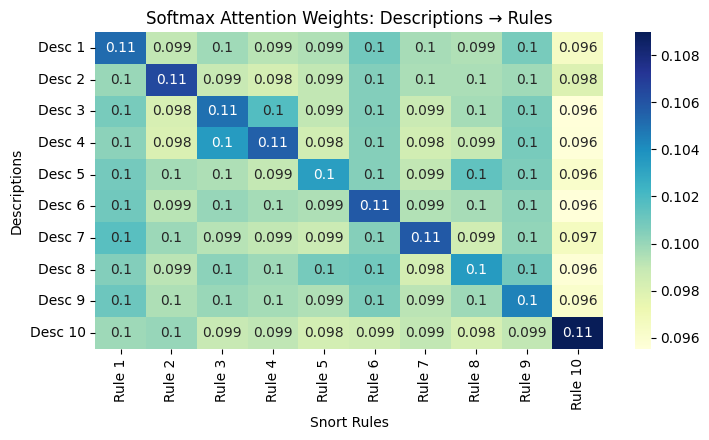

In [26]:
plot_attention_map(attn_matrix, title="Cosine Similarity Attention", annot=True)